<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Desafio 3: Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

## Imports y preparación dataset

In [1]:
import random
import io
import pickle
import json
import os
import glob
import re

from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import Callback
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.data import DataLoader
import torch.nn.functional as F
torch.set_float32_matmul_precision('high')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def set_seed(seed: int = 100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Para multi-GPU (si aplica)

    # Determinismo en cuDNN (puede impactar en performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [3]:
read_files = glob.glob("corpus/*.txt")

with open("corpus/full_article.txt", "wb") as outfile:
    for f in read_files:
        with open(f, "rb") as infile:
            outfile.write(infile.read())

In [4]:
corpus_file = open("corpus/full_article.txt", "rb")
full_article = corpus_file.read().decode("utf-8").lower()
display(f"Full article len: {len(full_article)}")
display(f"{full_article[4582:5015].replace('\n', ' ')}")

# corpus_file = open("corpus/Indiana_Jones_scripts.txt", "rb")
# full_article = corpus_file.read().decode("utf-8").lower().replace('\r\n', ' ')
# full_article = re.sub(" +" , " ", full_article)
# display(f"Full article len: {len(full_article)}")
# display(f"{full_article[4615:5200]}")

'Full article len: 5984769'

'but in the days of bilbo, and of frodo his heir, they suddenly  became, by no wish of their own, both important and renowned, and troubled      the counsels of the wise and the great.   those days, the third age of middle -earth, are now long past, and the  shape of all lands has been changed; but the regions in which hobbits then  lived were doubtless the same as those in which they still linger: the  north-west of the old world'

In [5]:
max_context_size = 200
chars_vocab = set(full_article)
vocab_size = len(chars_vocab)
display(f"Vocabulary len: {vocab_size}")

'Vocabulary len: 77'

In [6]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

### Proceso de Tokenizar

In [7]:
# Vamos a "tolkienizar" el texto completo
tokenized_text = [char2idx[ch] for ch in full_article]
display(tokenized_text[4582:5015])

[26,
 73,
 13,
 32,
 75,
 44,
 32,
 13,
 4,
 33,
 32,
 74,
 34,
 8,
 71,
 32,
 63,
 19,
 32,
 26,
 75,
 35,
 26,
 63,
 25,
 32,
 34,
 44,
 74,
 32,
 63,
 19,
 32,
 19,
 76,
 63,
 74,
 63,
 32,
 4,
 75,
 71,
 32,
 4,
 33,
 75,
 76,
 25,
 32,
 13,
 4,
 33,
 8,
 32,
 71,
 73,
 74,
 74,
 33,
 44,
 35,
 8,
 32,
 59,
 26,
 33,
 46,
 34,
 47,
 33,
 25,
 32,
 26,
 8,
 32,
 44,
 63,
 32,
 0,
 75,
 71,
 4,
 32,
 63,
 19,
 32,
 13,
 4,
 33,
 75,
 76,
 32,
 63,
 0,
 44,
 25,
 32,
 26,
 63,
 13,
 4,
 32,
 75,
 47,
 21,
 63,
 76,
 13,
 34,
 44,
 13,
 32,
 34,
 44,
 74,
 32,
 76,
 33,
 44,
 63,
 0,
 44,
 33,
 74,
 25,
 32,
 34,
 44,
 74,
 32,
 13,
 76,
 63,
 73,
 26,
 35,
 33,
 74,
 32,
 59,
 59,
 59,
 59,
 59,
 13,
 4,
 33,
 32,
 46,
 63,
 73,
 44,
 71,
 33,
 35,
 71,
 32,
 63,
 19,
 32,
 13,
 4,
 33,
 32,
 0,
 75,
 71,
 33,
 32,
 34,
 44,
 74,
 32,
 13,
 4,
 33,
 32,
 20,
 76,
 33,
 34,
 13,
 42,
 32,
 59,
 59,
 13,
 4,
 63,
 71,
 33,
 32,
 74,
 34,
 8,
 71,
 25,
 32,
 13,
 4,
 33,
 32,
 13,
 4,
 7

### Preparación de los dataset

In [8]:
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.2
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

## Modelos 

### RNN por caracter, modelos: SimpleRNN, GRU, LSTM

Se decidió usar Pytorch Lightning en lugar de Keras, porque en mi entorno local con GPU Tensorflow no soporta la última versión de CUDA 12.9 cuando Pytorch si lo hace. \
https://www.tensorflow.org/install/source?hl=en#gpu (Tensorflow 2.19 - CUDA 12.5) \
Como el entorno es parte de mi TF, preferí no cambiar de versiones.

In [ ]:
class CharDataset(Dataset):
    def __init__(self, tokenized_text, max_context_size, p_val=None):
        self.max_context_size = max_context_size
        if p_val is None:
            tokenized_sentences = [tokenized_text[init:init+self.max_context_size] for init in range(len(tokenized_text)-self.max_context_size+1)]
        else:
            num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))
            tokenized_sentences = [tokenized_text[init*self.max_context_size:init*(self.max_context_size+1)] for init in range(num_val)]
        self.X = np.array(tokenized_sentences[:-1])
        self.y = np.array(tokenized_sentences[1:])
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y  # Ambos de shape [context_size]


class CharRNN(pl.LightningModule):
    def __init__(self, vocab_size, hidden_size=300, lr=1e-4, rnn_type='rnn'):
        super().__init__()
        self.save_hyperparameters()
        # Selección dinámica del tipo de RNN
        rnn_cls = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}[rnn_type.lower()]
        self.rnn_type = rnn_type.lower()
        self.rnn = rnn_cls(input_size=vocab_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x_onehot = F.one_hot(x, num_classes=self.hparams.vocab_size).float()  # (B, T, V)
        if self.rnn_type == 'lstm':
            out, (_, _) = self.rnn(x_onehot)
        else:
            out, _ = self.rnn(x_onehot)
        out = self.dropout(out)
        logits = self.fc(out)  # (B, T, V)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch  # (B, T)
        logits = self(x)  # (B, T, V)
        loss = F.cross_entropy(logits.view(-1, self.hparams.vocab_size), y.view(-1))
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  # (B, T, V)
        probs = F.softmax(logits, dim=-1)
        B, T, V = probs.shape
        y_flat = y.view(-1)
        probs_flat = probs.view(-1, V)
        chosen_probs = probs_flat[torch.arange(B * T), y_flat]
        log_probs = torch.log(chosen_probs + 1e-8)
        # Acumulamos para el cálculo en on_validation_epoch_end
        if not hasattr(self, "val_log_probs"):
            self.val_log_probs = []
        self.val_log_probs.append(log_probs)

    def on_validation_epoch_end(self):
        all_log_probs = torch.cat(self.val_log_probs, dim=0)
        perplexity = torch.exp(-all_log_probs.mean()).item()
        if not hasattr(self, "ppl_history"):
            self.ppl_history = []
        self.ppl_history.append(perplexity)
        print(f"\nMean Perplexity: {perplexity:.4f}")
        self.log("perplexity", perplexity, prog_bar=True)
        self.val_log_probs.clear()

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=self.hparams.lr)

    def state_dict(self, *args, **kwargs):
        state = super().state_dict(*args, **kwargs)
        # Agregamos el historial manualmente
        state['ppl_history'] = self.ppl_history if hasattr(self, 'ppl_history') else []
        return state

    def load_state_dict(self, state_dict, *args, **kwargs):
        # Restauramos el historial si está
        self.ppl_history = state_dict.pop('ppl_history', [])
        super().load_state_dict(state_dict, *args, **kwargs)

Funcion para train de los 3 modelos y funciones para graficar y comparar

In [19]:
def train_rnn_variant(rnn_type, vocab_size, train_loader, val_loader, checkpoint_path=None):
    if checkpoint_path is None:
        model = CharRNN(vocab_size=vocab_size, rnn_type=rnn_type)
    else:
        model = CharRNN.load_from_checkpoint(checkpoint_path)
    print(model.hparams)
    early_stop = EarlyStopping(monitor="perplexity", patience=5, mode="min", verbose=True)
    checkpoint = ModelCheckpoint(monitor="perplexity", mode="min", filename="best-perplexity", verbose=True)
    trainer = pl.Trainer(max_epochs=50, accelerator="gpu", devices=1, callbacks=[early_stop, checkpoint])
    trainer.fit(model, train_loader, val_loader)
    torch.save(model, f"models/char_{rnn_type}_model.pt")
    torch.save(model.state_dict(), f"models/char_{rnn_type}_weights.pt")
    with open(f"results/char_{rnn_type}_perplexity_history.json", "w") as f:
        json.dump(model.ppl_history, f)
    return model

def print_perplexity(model, title):
    epoch_count = range(1, len(model.ppl_history[1:]) + 1)
    sns.lineplot(x=epoch_count, y=model.ppl_history[1:])    # No se muestra el perplexity medio para el sanity check
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.title(title)
    plt.show()

def compare_rnn(models, titles):
    plt.figure(figsize=(10, 6))
    for i, model in enumerate(models):
        y = model.ppl_history[1:]
        x = np.arange(1, len(y) + 1)
        line, = plt.plot(x, y, label=titles[i])
        # Mínimo
        min_idx = int(np.argmin(y)) + 1  # epoch correspondiente
        min_val = float(np.min(y))
        # Línea vertical
        plt.axvline(x=min_idx, linestyle="--", color=line.get_color(), alpha=0.6)
        # Texto con epoch y valor
        plt.text(min_idx, min_val + 0.1,  # levanto un poco para que no se solape
                 f"Epoch {min_idx}\nPPL {min_val:.2f}",
                 color=line.get_color(),
                 fontsize=9,
                 ha="center", va="bottom",
                 bbox=dict(facecolor="white", edgecolor=line.get_color(), boxstyle="round,pad=0.3", alpha=0.8))
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.title("Comparación de arquitecturas RNN")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def generate_text(model, start_string, char2idx, idx2char, max_context_size=100, gen_length=100, temperature=1.0):
    model.eval()
    input_chars = list(start_string)
    input_ids = [char2idx[c] for c in input_chars if c in char2idx][-max_context_size:]
    generated = input_chars.copy()
    for _ in range(gen_length):
        input_tensor = torch.tensor([input_ids], dtype=torch.long).to(model.device)
        with torch.no_grad():
            logits = model(input_tensor)
            last_logits = logits[0, -1]
            if temperature > 0:
                probs = torch.softmax(last_logits / temperature, dim=0)
                next_id = torch.multinomial(probs, num_samples=1).item()
            else:
                next_id = torch.argmax(logits[0, -1], dim=-1).item()  # En Greedy me quedo con la proxima mas probable
        input_ids.append(next_id)
        input_ids = input_ids[-max_context_size:]
        generated.append(idx2char[next_id])
    return ''.join(generated).replace("\n", " ")

Beam Search

In [11]:
def select_candidates(preds, num_beams, vocab_size, history_probs, history_tokens, temperature, mode):
    pred_large = []
    for idx, pp in enumerate(preds):
        pred_large.extend(np.log(pp + 1e-10) + history_probs[idx])  # log suma acumulada
    pred_large = np.array(pred_large)
    if mode == 'det':
        idx_select = np.argsort(pred_large)[::-1][:num_beams]
    elif mode == 'sto':
        idx_select = np.random.choice(
            np.arange(pred_large.shape[0]), num_beams, p=torch.softmax(pred_large / temperature)
        )
    else:
        raise ValueError(f'Modo no soportado: {mode}')
    # reconstruir nuevas secuencias
    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )
    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

def beam_search(model, input_str, char2idx, idx2char, num_beams=3, num_chars=100, temperature=1.0, mode='det', max_context_size=100):
    model.eval()
    device = next(model.parameters()).device
    input_ids = [char2idx[c] for c in input_str if c in char2idx]
    input_ids = input_ids[-max_context_size:]
    vocab_size = len(char2idx)
    with torch.no_grad():
        input_tensor = torch.tensor([input_ids], dtype=torch.long, device=device)
        logits = model(input_tensor)
        probs = F.softmax(logits[0, -1], dim=-1).cpu().numpy()
    # inicializar beam
    history_probs = [0] * num_beams
    history_tokens = [np.array(input_ids)] * num_beams

    history_probs, history_tokens = select_candidates(
        [probs], num_beams, vocab_size, history_probs, history_tokens, temperature, mode
    )
    # loop beam search
    for i in range(num_chars - 1):
        preds = []
        for hist in history_tokens:
            input_update = hist[-max_context_size:]
            input_tensor = torch.tensor([input_update], dtype=torch.long, device=device)
            with torch.no_grad():
                logits = model(input_tensor)
                probs = F.softmax(logits[0, -1], dim=-1).cpu().numpy()
            preds.append(probs)
        history_probs, history_tokens = select_candidates(
            preds, num_beams, vocab_size, history_probs, history_tokens, temperature, mode
        )
    best_sequence = history_tokens[0]
    return ''.join(idx2char[idx] for idx in best_sequence)

Cargamos los datos para pasarlo a los modelos

In [12]:
# Dataset y loaders
train_ds = CharDataset(train_text, max_context_size)
val_ds = CharDataset(val_text, max_context_size)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True, num_workers=0)   # Windows num_workers=0
val_loader = DataLoader(val_ds, batch_size=1024, num_workers=0, drop_last=True)

#### Simple RNN

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | RNN     | 113 K  | train
1 | dropout | Dropout | 0      | train
2 | fc      | Linear  | 23.2 K | train
--------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.548     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


"hidden_size": 300
"lr":          0.0001
"rnn_type":    rnn
"vocab_size":  77
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Pablo\IA-repos\Desafios_NLP\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]
Mean Perplexity: 77.8167
                                                                           

c:\Users\Pablo\IA-repos\Desafios_NLP\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 4676/4676 [14:39<00:00,  5.32it/s, v_num=50]
Mean Perplexity: 8.5926
Epoch 0: 100%|██████████| 4676/4676 [18:08<00:00,  4.30it/s, v_num=50, perplexity=8.590]

Metric perplexity improved. New best score: 8.593
Epoch 0, global step 4676: 'perplexity' reached 8.59258 (best 8.59258), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 1: 100%|██████████| 4676/4676 [14:36<00:00,  5.34it/s, v_num=50, perplexity=8.590]
Mean Perplexity: 7.2467
Epoch 1: 100%|██████████| 4676/4676 [18:03<00:00,  4.31it/s, v_num=50, perplexity=7.250]

Metric perplexity improved by 1.346 >= min_delta = 0.0. New best score: 7.247
Epoch 1, global step 9352: 'perplexity' reached 7.24673 (best 7.24673), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 2: 100%|██████████| 4676/4676 [14:37<00:00,  5.33it/s, v_num=50, perplexity=7.250]
Mean Perplexity: 6.6052
Epoch 2: 100%|██████████| 4676/4676 [18:05<00:00,  4.31it/s, v_num=50, perplexity=6.610]

Metric perplexity improved by 0.642 >= min_delta = 0.0. New best score: 6.605
Epoch 2, global step 14028: 'perplexity' reached 6.60516 (best 6.60516), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 3: 100%|██████████| 4676/4676 [14:35<00:00,  5.34it/s, v_num=50, perplexity=6.610]
Mean Perplexity: 6.2721
Epoch 3: 100%|██████████| 4676/4676 [18:03<00:00,  4.32it/s, v_num=50, perplexity=6.270]

Metric perplexity improved by 0.333 >= min_delta = 0.0. New best score: 6.272
Epoch 3, global step 18704: 'perplexity' reached 6.27205 (best 6.27205), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 4: 100%|██████████| 4676/4676 [14:35<00:00,  5.34it/s, v_num=50, perplexity=6.270]
Mean Perplexity: 6.0190
Epoch 4: 100%|██████████| 4676/4676 [18:03<00:00,  4.32it/s, v_num=50, perplexity=6.020]

Metric perplexity improved by 0.253 >= min_delta = 0.0. New best score: 6.019
Epoch 4, global step 23380: 'perplexity' reached 6.01897 (best 6.01897), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 5: 100%|██████████| 4676/4676 [14:35<00:00,  5.34it/s, v_num=50, perplexity=6.020]
Mean Perplexity: 5.8726
Epoch 5: 100%|██████████| 4676/4676 [18:02<00:00,  4.32it/s, v_num=50, perplexity=5.870]

Metric perplexity improved by 0.146 >= min_delta = 0.0. New best score: 5.873
Epoch 5, global step 28056: 'perplexity' reached 5.87259 (best 5.87259), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 6: 100%|██████████| 4676/4676 [14:35<00:00,  5.34it/s, v_num=50, perplexity=5.870]
Mean Perplexity: 5.7638
Epoch 6: 100%|██████████| 4676/4676 [18:03<00:00,  4.31it/s, v_num=50, perplexity=5.760]

Metric perplexity improved by 0.109 >= min_delta = 0.0. New best score: 5.764
Epoch 6, global step 32732: 'perplexity' reached 5.76376 (best 5.76376), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 7: 100%|██████████| 4676/4676 [14:38<00:00,  5.32it/s, v_num=50, perplexity=5.760]
Mean Perplexity: 5.6971
Epoch 7: 100%|██████████| 4676/4676 [18:10<00:00,  4.29it/s, v_num=50, perplexity=5.700]

Metric perplexity improved by 0.067 >= min_delta = 0.0. New best score: 5.697
Epoch 7, global step 37408: 'perplexity' reached 5.69712 (best 5.69712), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 8: 100%|██████████| 4676/4676 [14:41<00:00,  5.30it/s, v_num=50, perplexity=5.700]
Mean Perplexity: 5.6318
Epoch 8: 100%|██████████| 4676/4676 [18:10<00:00,  4.29it/s, v_num=50, perplexity=5.630]

Metric perplexity improved by 0.065 >= min_delta = 0.0. New best score: 5.632
Epoch 8, global step 42084: 'perplexity' reached 5.63181 (best 5.63181), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 9: 100%|██████████| 4676/4676 [14:38<00:00,  5.32it/s, v_num=50, perplexity=5.630]
Mean Perplexity: 5.5903
Epoch 9: 100%|██████████| 4676/4676 [18:07<00:00,  4.30it/s, v_num=50, perplexity=5.590]

Metric perplexity improved by 0.042 >= min_delta = 0.0. New best score: 5.590
Epoch 9, global step 46760: 'perplexity' reached 5.59029 (best 5.59029), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 10: 100%|██████████| 4676/4676 [14:37<00:00,  5.33it/s, v_num=50, perplexity=5.590]
Mean Perplexity: 5.5599
Epoch 10: 100%|██████████| 4676/4676 [18:05<00:00,  4.31it/s, v_num=50, perplexity=5.560]

Metric perplexity improved by 0.030 >= min_delta = 0.0. New best score: 5.560
Epoch 10, global step 51436: 'perplexity' reached 5.55991 (best 5.55991), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 11: 100%|██████████| 4676/4676 [14:37<00:00,  5.33it/s, v_num=50, perplexity=5.560]
Mean Perplexity: 5.5012
Epoch 11: 100%|██████████| 4676/4676 [18:06<00:00,  4.30it/s, v_num=50, perplexity=5.500]

Metric perplexity improved by 0.059 >= min_delta = 0.0. New best score: 5.501
Epoch 11, global step 56112: 'perplexity' reached 5.50120 (best 5.50120), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 12: 100%|██████████| 4676/4676 [14:36<00:00,  5.33it/s, v_num=50, perplexity=5.500]
Mean Perplexity: 5.4865
Epoch 12: 100%|██████████| 4676/4676 [18:04<00:00,  4.31it/s, v_num=50, perplexity=5.490]

Metric perplexity improved by 0.015 >= min_delta = 0.0. New best score: 5.486
Epoch 12, global step 60788: 'perplexity' reached 5.48648 (best 5.48648), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 13: 100%|██████████| 4676/4676 [14:37<00:00,  5.33it/s, v_num=50, perplexity=5.490]
Mean Perplexity: 5.4678
Epoch 13: 100%|██████████| 4676/4676 [18:14<00:00,  4.27it/s, v_num=50, perplexity=5.470]

Metric perplexity improved by 0.019 >= min_delta = 0.0. New best score: 5.468
Epoch 13, global step 65464: 'perplexity' reached 5.46782 (best 5.46782), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 14: 100%|██████████| 4676/4676 [14:43<00:00,  5.29it/s, v_num=50, perplexity=5.470]
Mean Perplexity: 5.4657
Epoch 14: 100%|██████████| 4676/4676 [18:17<00:00,  4.26it/s, v_num=50, perplexity=5.470]

Metric perplexity improved by 0.002 >= min_delta = 0.0. New best score: 5.466
Epoch 14, global step 70140: 'perplexity' reached 5.46568 (best 5.46568), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 15: 100%|██████████| 4676/4676 [14:45<00:00,  5.28it/s, v_num=50, perplexity=5.470]
Mean Perplexity: 5.4399
Epoch 15: 100%|██████████| 4676/4676 [18:13<00:00,  4.28it/s, v_num=50, perplexity=5.440]

Metric perplexity improved by 0.026 >= min_delta = 0.0. New best score: 5.440
Epoch 15, global step 74816: 'perplexity' reached 5.43993 (best 5.43993), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 16: 100%|██████████| 4676/4676 [14:37<00:00,  5.33it/s, v_num=50, perplexity=5.440]
Mean Perplexity: 5.4320
Epoch 16: 100%|██████████| 4676/4676 [18:05<00:00,  4.31it/s, v_num=50, perplexity=5.430]

Metric perplexity improved by 0.008 >= min_delta = 0.0. New best score: 5.432
Epoch 16, global step 79492: 'perplexity' reached 5.43200 (best 5.43200), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 17: 100%|██████████| 4676/4676 [14:40<00:00,  5.31it/s, v_num=50, perplexity=5.430]
Mean Perplexity: 5.4526
Epoch 17: 100%|██████████| 4676/4676 [18:08<00:00,  4.30it/s, v_num=50, perplexity=5.450]

Epoch 17, global step 84168: 'perplexity' was not in top 1


Epoch 18: 100%|██████████| 4676/4676 [14:40<00:00,  5.31it/s, v_num=50, perplexity=5.450]
Mean Perplexity: 5.4319
Epoch 18: 100%|██████████| 4676/4676 [18:09<00:00,  4.29it/s, v_num=50, perplexity=5.430]

Metric perplexity improved by 0.000 >= min_delta = 0.0. New best score: 5.432
Epoch 18, global step 88844: 'perplexity' reached 5.43192 (best 5.43192), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 19: 100%|██████████| 4676/4676 [14:38<00:00,  5.32it/s, v_num=50, perplexity=5.430]
Mean Perplexity: 5.4106
Epoch 19: 100%|██████████| 4676/4676 [18:06<00:00,  4.30it/s, v_num=50, perplexity=5.410]

Metric perplexity improved by 0.021 >= min_delta = 0.0. New best score: 5.411
Epoch 19, global step 93520: 'perplexity' reached 5.41058 (best 5.41058), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_50\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 20: 100%|██████████| 4676/4676 [14:40<00:00,  5.31it/s, v_num=50, perplexity=5.410]
Mean Perplexity: 5.4161
Epoch 20: 100%|██████████| 4676/4676 [18:09<00:00,  4.29it/s, v_num=50, perplexity=5.420]

Epoch 20, global step 98196: 'perplexity' was not in top 1


Epoch 21: 100%|██████████| 4676/4676 [14:40<00:00,  5.31it/s, v_num=50, perplexity=5.420]
Mean Perplexity: 5.4333
Epoch 21: 100%|██████████| 4676/4676 [18:08<00:00,  4.30it/s, v_num=50, perplexity=5.430]

Epoch 21, global step 102872: 'perplexity' was not in top 1


Epoch 22: 100%|██████████| 4676/4676 [14:38<00:00,  5.32it/s, v_num=50, perplexity=5.430]
Mean Perplexity: 5.4157
Epoch 22: 100%|██████████| 4676/4676 [18:07<00:00,  4.30it/s, v_num=50, perplexity=5.420]

Epoch 22, global step 107548: 'perplexity' was not in top 1


Epoch 23: 100%|██████████| 4676/4676 [14:42<00:00,  5.30it/s, v_num=50, perplexity=5.420]
Mean Perplexity: 5.4402
Epoch 23: 100%|██████████| 4676/4676 [18:12<00:00,  4.28it/s, v_num=50, perplexity=5.440]

Epoch 23, global step 112224: 'perplexity' was not in top 1


Epoch 24: 100%|██████████| 4676/4676 [14:37<00:00,  5.33it/s, v_num=50, perplexity=5.440]
Mean Perplexity: 5.4399
Epoch 24: 100%|██████████| 4676/4676 [18:04<00:00,  4.31it/s, v_num=50, perplexity=5.440]

Monitored metric perplexity did not improve in the last 5 records. Best score: 5.411. Signaling Trainer to stop.
Epoch 24, global step 116900: 'perplexity' was not in top 1


Epoch 24: 100%|██████████| 4676/4676 [18:04<00:00,  4.31it/s, v_num=50, perplexity=5.440]


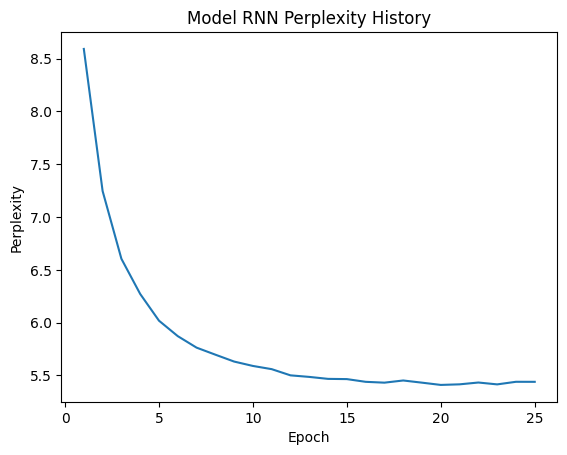

In [21]:
model_rnn  = train_rnn_variant('rnn',  vocab_size, train_loader, val_loader,) #checkpoint_path="lightning_logs/version_44/checkpoints/best-perplexity.ckpt",)
print_perplexity(model_rnn, "Model RNN Perplexity History")

#### GRU

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | GRU     | 341 K  | train
1 | dropout | Dropout | 0      | train
2 | fc      | Linear  | 23.2 K | train
--------------------------------------------
364 K     Trainable params
0         Non-trainable params
364 K     Total params
1.457     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


"hidden_size": 300
"lr":          0.0001
"rnn_type":    gru
"vocab_size":  77
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]
Mean Perplexity: 77.0357
Epoch 0: 100%|██████████| 4676/4676 [03:59<00:00, 19.54it/s, v_num=46]     
Mean Perplexity: 6.7094
Epoch 0: 100%|██████████| 4676/4676 [04:29<00:00, 17.38it/s, v_num=46, perplexity=6.710]

Metric perplexity improved. New best score: 6.709
Epoch 0, global step 4676: 'perplexity' reached 6.70940 (best 6.70940), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_46\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 1: 100%|██████████| 4676/4676 [03:58<00:00, 19.60it/s, v_num=46, perplexity=6.710]
Mean Perplexity: 5.3030
Epoch 1: 100%|██████████| 4676/4676 [04:28<00:00, 17.44it/s, v_num=46, perplexity=5.300]

Metric perplexity improved by 1.406 >= min_delta = 0.0. New best score: 5.303
Epoch 1, global step 9352: 'perplexity' reached 5.30303 (best 5.30303), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_46\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 2: 100%|██████████| 4676/4676 [03:58<00:00, 19.60it/s, v_num=46, perplexity=5.300]
Mean Perplexity: 4.9260
Epoch 2: 100%|██████████| 4676/4676 [04:28<00:00, 17.44it/s, v_num=46, perplexity=4.930]

Metric perplexity improved by 0.377 >= min_delta = 0.0. New best score: 4.926
Epoch 2, global step 14028: 'perplexity' reached 4.92603 (best 4.92603), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_46\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 3: 100%|██████████| 4676/4676 [03:59<00:00, 19.52it/s, v_num=46, perplexity=4.930]
Mean Perplexity: 4.7833
Epoch 3: 100%|██████████| 4676/4676 [04:29<00:00, 17.37it/s, v_num=46, perplexity=4.780]

Metric perplexity improved by 0.143 >= min_delta = 0.0. New best score: 4.783
Epoch 3, global step 18704: 'perplexity' reached 4.78327 (best 4.78327), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_46\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 4: 100%|██████████| 4676/4676 [04:02<00:00, 19.28it/s, v_num=46, perplexity=4.780]
Mean Perplexity: 4.7231
Epoch 4: 100%|██████████| 4676/4676 [04:32<00:00, 17.18it/s, v_num=46, perplexity=4.720]

Metric perplexity improved by 0.060 >= min_delta = 0.0. New best score: 4.723
Epoch 4, global step 23380: 'perplexity' reached 4.72311 (best 4.72311), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_46\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 5: 100%|██████████| 4676/4676 [03:58<00:00, 19.57it/s, v_num=46, perplexity=4.720]
Mean Perplexity: 4.6974
Epoch 5: 100%|██████████| 4676/4676 [04:28<00:00, 17.40it/s, v_num=46, perplexity=4.700]

Metric perplexity improved by 0.026 >= min_delta = 0.0. New best score: 4.697
Epoch 5, global step 28056: 'perplexity' reached 4.69741 (best 4.69741), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_46\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 6: 100%|██████████| 4676/4676 [03:58<00:00, 19.59it/s, v_num=46, perplexity=4.700]
Mean Perplexity: 4.7037
Epoch 6: 100%|██████████| 4676/4676 [04:28<00:00, 17.42it/s, v_num=46, perplexity=4.700]

Epoch 6, global step 32732: 'perplexity' was not in top 1


Epoch 7: 100%|██████████| 4676/4676 [03:59<00:00, 19.55it/s, v_num=46, perplexity=4.700]
Mean Perplexity: 4.7219
Epoch 7: 100%|██████████| 4676/4676 [04:28<00:00, 17.39it/s, v_num=46, perplexity=4.720]

Epoch 7, global step 37408: 'perplexity' was not in top 1


Epoch 8: 100%|██████████| 4676/4676 [03:59<00:00, 19.53it/s, v_num=46, perplexity=4.720]
Mean Perplexity: 4.7589
Epoch 8: 100%|██████████| 4676/4676 [04:29<00:00, 17.38it/s, v_num=46, perplexity=4.760]

Epoch 8, global step 42084: 'perplexity' was not in top 1


Epoch 9: 100%|██████████| 4676/4676 [03:59<00:00, 19.54it/s, v_num=46, perplexity=4.760]
Mean Perplexity: 4.8019
Epoch 9: 100%|██████████| 4676/4676 [04:28<00:00, 17.39it/s, v_num=46, perplexity=4.800]

Epoch 9, global step 46760: 'perplexity' was not in top 1


Epoch 10: 100%|██████████| 4676/4676 [04:00<00:00, 19.48it/s, v_num=46, perplexity=4.800]
Mean Perplexity: 4.8630
Epoch 10: 100%|██████████| 4676/4676 [04:37<00:00, 16.83it/s, v_num=46, perplexity=4.860]

Monitored metric perplexity did not improve in the last 5 records. Best score: 4.697. Signaling Trainer to stop.
Epoch 10, global step 51436: 'perplexity' was not in top 1


Epoch 10: 100%|██████████| 4676/4676 [04:37<00:00, 16.83it/s, v_num=46, perplexity=4.860]


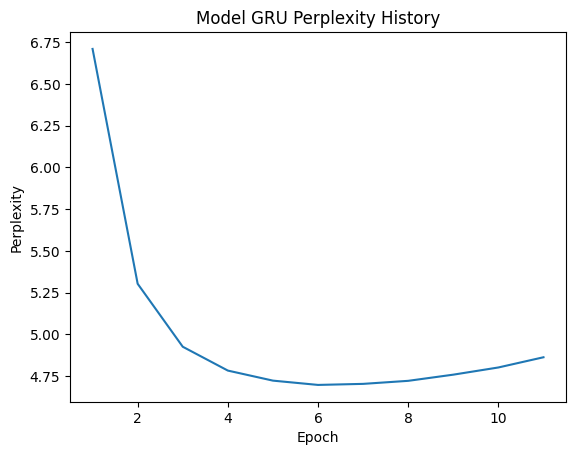

In [14]:
model_gru  = train_rnn_variant('gru',  vocab_size, train_loader, val_loader)
print_perplexity(model_gru, "Model GRU Perplexity History")

#### LSTM

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | rnn     | LSTM    | 454 K  | train
1 | dropout | Dropout | 0      | train
2 | fc      | Linear  | 23.2 K | train
--------------------------------------------
477 K     Trainable params
0         Non-trainable params
477 K     Total params
1.912     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


"hidden_size": 300
"lr":          0.0001
"rnn_type":    lstm
"vocab_size":  77
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 21.89it/s]
Mean Perplexity: 77.6550
                                                                           

c:\Users\Pablo\IA-repos\Desafios_NLP\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Pablo\IA-repos\Desafios_NLP\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 4676/4676 [04:16<00:00, 18.23it/s, v_num=47]
Mean Perplexity: 9.0152
Epoch 0: 100%|██████████| 4676/4676 [04:55<00:00, 15.84it/s, v_num=47, perplexity=9.020]

Metric perplexity improved. New best score: 9.015
Epoch 0, global step 4676: 'perplexity' reached 9.01522 (best 9.01522), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_47\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 1: 100%|██████████| 4676/4676 [04:16<00:00, 18.24it/s, v_num=47, perplexity=9.020]
Mean Perplexity: 6.4307
Epoch 1: 100%|██████████| 4676/4676 [04:55<00:00, 15.82it/s, v_num=47, perplexity=6.430]

Metric perplexity improved by 2.585 >= min_delta = 0.0. New best score: 6.431
Epoch 1, global step 9352: 'perplexity' reached 6.43072 (best 6.43072), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_47\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 2: 100%|██████████| 4676/4676 [04:16<00:00, 18.26it/s, v_num=47, perplexity=6.430]
Mean Perplexity: 5.4802
Epoch 2: 100%|██████████| 4676/4676 [04:54<00:00, 15.88it/s, v_num=47, perplexity=5.480]

Metric perplexity improved by 0.951 >= min_delta = 0.0. New best score: 5.480
Epoch 2, global step 14028: 'perplexity' reached 5.48015 (best 5.48015), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_47\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 3: 100%|██████████| 4676/4676 [04:16<00:00, 18.23it/s, v_num=47, perplexity=5.480]
Mean Perplexity: 5.0596
Epoch 3: 100%|██████████| 4676/4676 [04:56<00:00, 15.78it/s, v_num=47, perplexity=5.060]

Metric perplexity improved by 0.421 >= min_delta = 0.0. New best score: 5.060
Epoch 3, global step 18704: 'perplexity' reached 5.05956 (best 5.05956), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_47\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 4: 100%|██████████| 4676/4676 [04:16<00:00, 18.23it/s, v_num=47, perplexity=5.060]
Mean Perplexity: 4.8287
Epoch 4: 100%|██████████| 4676/4676 [04:55<00:00, 15.83it/s, v_num=47, perplexity=4.830]

Metric perplexity improved by 0.231 >= min_delta = 0.0. New best score: 4.829
Epoch 4, global step 23380: 'perplexity' reached 4.82874 (best 4.82874), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_47\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 5: 100%|██████████| 4676/4676 [04:16<00:00, 18.25it/s, v_num=47, perplexity=4.830]
Mean Perplexity: 4.7076
Epoch 5: 100%|██████████| 4676/4676 [04:56<00:00, 15.79it/s, v_num=47, perplexity=4.710]

Metric perplexity improved by 0.121 >= min_delta = 0.0. New best score: 4.708
Epoch 5, global step 28056: 'perplexity' reached 4.70763 (best 4.70763), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_47\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 6: 100%|██████████| 4676/4676 [04:16<00:00, 18.24it/s, v_num=47, perplexity=4.710]
Mean Perplexity: 4.6235
Epoch 6: 100%|██████████| 4676/4676 [04:56<00:00, 15.78it/s, v_num=47, perplexity=4.620]

Metric perplexity improved by 0.084 >= min_delta = 0.0. New best score: 4.624
Epoch 6, global step 32732: 'perplexity' reached 4.62351 (best 4.62351), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_47\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 7: 100%|██████████| 4676/4676 [04:16<00:00, 18.23it/s, v_num=47, perplexity=4.620]
Mean Perplexity: 4.5591
Epoch 7: 100%|██████████| 4676/4676 [04:54<00:00, 15.88it/s, v_num=47, perplexity=4.560]

Metric perplexity improved by 0.064 >= min_delta = 0.0. New best score: 4.559
Epoch 7, global step 37408: 'perplexity' reached 4.55908 (best 4.55908), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_47\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 8: 100%|██████████| 4676/4676 [04:15<00:00, 18.30it/s, v_num=47, perplexity=4.560]
Mean Perplexity: 4.5628
Epoch 8: 100%|██████████| 4676/4676 [04:48<00:00, 16.19it/s, v_num=47, perplexity=4.560]

Epoch 8, global step 42084: 'perplexity' was not in top 1


Epoch 9: 100%|██████████| 4676/4676 [04:15<00:00, 18.31it/s, v_num=47, perplexity=4.560]
Mean Perplexity: 4.5501
Epoch 9: 100%|██████████| 4676/4676 [04:48<00:00, 16.20it/s, v_num=47, perplexity=4.550]

Metric perplexity improved by 0.009 >= min_delta = 0.0. New best score: 4.550
Epoch 9, global step 46760: 'perplexity' reached 4.55008 (best 4.55008), saving model to 'c:\\Users\\Pablo\\IA-repos\\Desafios_NLP\\desafio3\\lightning_logs\\version_47\\checkpoints\\best-perplexity.ckpt' as top 1


Epoch 10: 100%|██████████| 4676/4676 [04:15<00:00, 18.31it/s, v_num=47, perplexity=4.550]
Mean Perplexity: 4.6030
Epoch 10: 100%|██████████| 4676/4676 [04:48<00:00, 16.20it/s, v_num=47, perplexity=4.600]

Epoch 10, global step 51436: 'perplexity' was not in top 1


Epoch 11: 100%|██████████| 4676/4676 [04:15<00:00, 18.31it/s, v_num=47, perplexity=4.600]
Mean Perplexity: 4.6206
Epoch 11: 100%|██████████| 4676/4676 [04:48<00:00, 16.21it/s, v_num=47, perplexity=4.620]

Epoch 11, global step 56112: 'perplexity' was not in top 1


Epoch 12: 100%|██████████| 4676/4676 [04:15<00:00, 18.33it/s, v_num=47, perplexity=4.620]
Mean Perplexity: 4.6283
Epoch 12: 100%|██████████| 4676/4676 [04:48<00:00, 16.22it/s, v_num=47, perplexity=4.630]

Epoch 12, global step 60788: 'perplexity' was not in top 1


Epoch 13: 100%|██████████| 4676/4676 [04:15<00:00, 18.34it/s, v_num=47, perplexity=4.630]
Mean Perplexity: 4.6639
Epoch 13: 100%|██████████| 4676/4676 [04:48<00:00, 16.22it/s, v_num=47, perplexity=4.660]

Epoch 13, global step 65464: 'perplexity' was not in top 1


Epoch 14: 100%|██████████| 4676/4676 [04:14<00:00, 18.36it/s, v_num=47, perplexity=4.660]
Mean Perplexity: 4.7061
Epoch 14: 100%|██████████| 4676/4676 [04:47<00:00, 16.25it/s, v_num=47, perplexity=4.710]

Monitored metric perplexity did not improve in the last 5 records. Best score: 4.550. Signaling Trainer to stop.
Epoch 14, global step 70140: 'perplexity' was not in top 1


Epoch 14: 100%|██████████| 4676/4676 [04:47<00:00, 16.25it/s, v_num=47, perplexity=4.710]


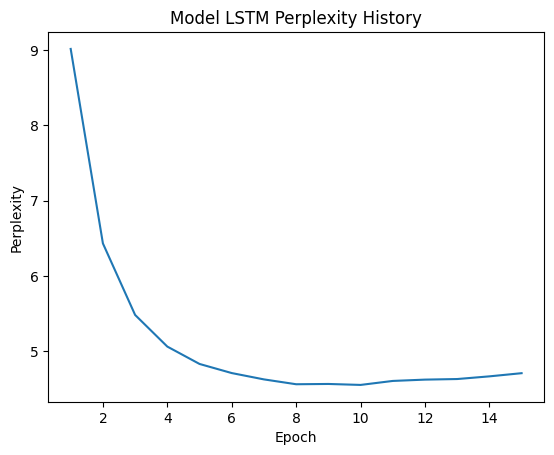

In [15]:
model_lstm = train_rnn_variant('lstm', vocab_size, train_loader, val_loader)
print_perplexity(model_lstm, "Model LSTM Perplexity History")

### Pruebas de Modelos

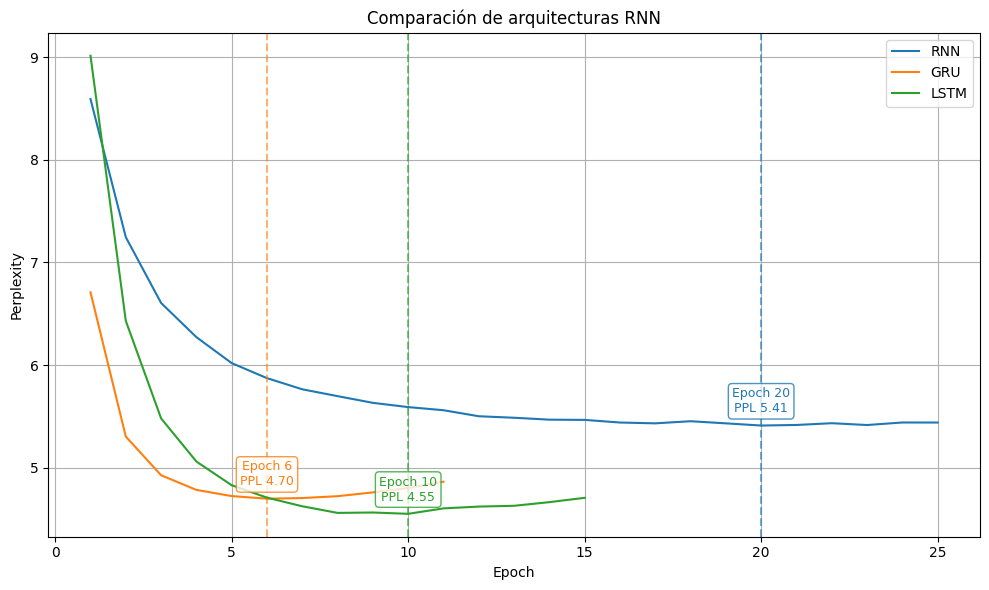

In [22]:
compare_rnn([model_rnn, model_gru, model_lstm], ["RNN", "GRU", "LSTM"])

La red SimpleRNN se demoró mas de 300 min, mientras que la red GRU tomó 50 min aprox en entrenar para el mismo corpus. Por su lado, la red LSTM se tomo aproximadamente 74 min.

La RNN es mas lenta que la GRU y la LSTM pese a tener menos parámetros en cuanto a it/s.
La nn.RNN no está optimizada como nn.GRU o nn.LSTM
- Implementación menos eficiente (sin kernel fusionado)
- En PyTorch, nn.GRU y nn.LSTM tienen implementaciones altamente optimizadas en C++/CUDA.
- Estas implementaciones aprovechan kernel fusion y primitivas optimizadas para GPU (cuDNN).
- nn.RNN, en cambio, usa un kernel más general y no siempre está soportado por cuDNN (por ser menos usada y menos estable numéricamente).

Podemos ver como GRU y LSTM al ser redes mas complejas logran capturar el corpus en menos epochs que la RNN simple.

Considerando el tiempo de entrenamiento y el perplexity alcanzado, para este caso la GRU parece ser la mejor opción (usa menos parámetros que la LSTM).

In [27]:
prompt = "One Ring to rule them all, ".lower()
# prompt = "Hidden in the temple "

In [28]:
# Greedy
print("RNN:\n",  generate_text(model_rnn, prompt, char2idx, idx2char, max_context_size=max_context_size, gen_length=100, temperature=0))
print("\nGRU:\n",  generate_text(model_gru, prompt, char2idx, idx2char, max_context_size=max_context_size, gen_length=100, temperature=0))
print("\nLSTM:\n", generate_text(model_lstm, prompt, char2idx, idx2char, max_context_size=max_context_size, gen_length=100, temperature=0))

RNN:
 one ring to rule them all, and the  the hills of the ring was still the stars of the world that he had been  still and strong a

GRU:
 one ring to rule them all, and they were still  going to see the shire and the shire we shall see the ring to the  dark lord an

LSTM:
 one ring to rule them all, and they were still  and strange to the shire.   'there is a path that i have not tried to see the s


In [29]:
# Temperature
print("RNN:\n",  generate_text(model_rnn, prompt, char2idx, idx2char, max_context_size=max_context_size, gen_length=100, temperature=0.7))
print("\nGRU:\n",  generate_text(model_gru, prompt, char2idx, idx2char, max_context_size=max_context_size, gen_length=100, temperature=0.7))
print("\nLSTM:\n", generate_text(model_lstm, prompt, char2idx, idx2char, max_context_size=max_context_size, gen_length=100, temperature=0.7))

RNN:
 one ring to rule them all,  and at the lose of the window of the bad show there shall fell        courteacl, trambling the midd

GRU:
 one ring to rule them all, i went down the wind.   “who have 'it is not known that it was to my name made! and you shall not be

LSTM:
 one ring to rule them all,  and need of watchers and smokes of mordor. they dwelt in them in the  desise and surprise their woo


In [32]:
# Temperature
print("RNN:\n",  generate_text(model_rnn, prompt, char2idx, idx2char, max_context_size=max_context_size, gen_length=100, temperature=1.0))
print("\nGRU:\n",  generate_text(model_gru, prompt, char2idx, idx2char, max_context_size=max_context_size, gen_length=100, temperature=1.0))
print("\nLSTM:\n", generate_text(model_lstm, prompt, char2idx, idx2char, max_context_size=max_context_size, gen_length=100, temperature=1.0))

RNN:
 one ring to rule them all,  in the  will loided face. the ushace are face was among tteen and ladder. but for gind!' said frodo

GRU:
 one ring to rule them all, once down farabor that the borght was the land of  the eldar, wain the word was bening on my  far hi

LSTM:
 one ring to rule them all, and struggled aside from the face.  'how wherever!' said sam! ' said gandalf, 'in that gentler cloth


In [30]:
beam_output = beam_search(model=model_rnn, input_str=prompt, char2idx=char2idx, idx2char=idx2char, num_beams=5, num_chars=100, temperature=0.7, mode="det", max_context_size=max_context_size)
print(f"RNN: \n{beam_output}")
beam_output = beam_search(model=model_gru, input_str=prompt, char2idx=char2idx, idx2char=idx2char, num_beams=5, num_chars=100, temperature=0.7, mode="det", max_context_size=max_context_size)
print(f"\nGRU: \n{beam_output}")
beam_output = beam_search(model=model_lstm, input_str=prompt, char2idx=char2idx, idx2char=idx2char, num_beams=5, num_chars=100, temperature=0.7, mode="det", max_context_size=max_context_size)
print(f"\nLSTM: \n{beam_output}")

RNN: 
one ring to rule them all, and they were all the 
shadows of the mountains, and they came to the house of the elves, and they 


GRU: 
one ring to rule them all, and they were still heard that they 
would not be seen in the darkness of the elves, and there were 

LSTM: 
one ring to rule them all, and there were no more than a little while. 

there was no sign of their hearts, and they were still


El texto generado por los 3 metodos no es el mas coherente pero si tiene relación con el lexico usando en los libros de "Lord of the Rings"